# Feature Selection

Choosing the most effective variables



In [213]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr

plt.style.use('seaborn')
import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
import missingno as msno
import datetime
import pickle

In [214]:
# load dataframes
with open("../pickles/df_after_feature_engineering_new.pkl", "rb") as f:
    df = pickle.load(f)

In [215]:
df.head()

,gameID,leagueID,season,date,homeTeamID,awayTeamID,home_Goals,away_Goals,home_GoalsHalfTime,away_GoalsHalfTime,...,home_rolling_ppda,away_rolling_ppda,home_blocked_shot_ratio,away_blocked_shot_ratio,home_shot_conceded_ratio,away_shot_conceded_ratio,home_discipline_score_avg,away_discipline_score_avg,points_diff,recent_form_diff
5437,6185,5,2014,2014-08-08 19:30:00,177,161,2,2,2,1,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
5438,6186,5,2014,2014-08-09 20:00:00,162,164,3,3,1,2,...,0.0,0.0,0.363636,0.166667,0.363636,0.166667,-22.999770,-17.999820,-2.0,0.0
5439,6187,5,2014,2014-08-09 20:00:00,209,165,0,3,0,3,...,0.0,0.0,0.111111,0.055556,0.333333,0.055556,-17.499913,-15.499923,-2.0,0.0
5440,6188,5,2014,2014-08-09 20:00:00,169,175,0,2,0,1,...,0.0,0.0,0.222222,0.058823,0.333333,0.470588,-16.333279,-15.333282,-2.0,0.0
5441,6189,5,2014,2014-08-09 20:00:00,160,180,0,0,0,0,...,0.0,0.0,0.090663,0.266666,0.634644,0.400000,-13.249967,-16.999958,-2.0,0.0


In [216]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12680 entries, 5437 to 12679
Data columns (total 80 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   gameID                        12680 non-null  int64         
 1   leagueID                      12680 non-null  int64         
 2   season                        12680 non-null  int64         
 3   date                          12680 non-null  datetime64[ns]
 4   homeTeamID                    12680 non-null  int64         
 5   awayTeamID                    12680 non-null  int64         
 6   home_Goals                    12680 non-null  int64         
 7   away_Goals                    12680 non-null  int64         
 8   home_GoalsHalfTime            12680 non-null  int64         
 9   away_GoalsHalfTime            12680 non-null  int64         
 10  home_xGoals                   12680 non-null  float64       
 11  home_shots               

lets droop columns that are high related with the target value and columns that are unnecesary (like date, duplicates...)

In [217]:
cols_to_drop = ['home_Goals','away_Goals','home_GoalsHalfTime','away_GoalsHalfTime','date',
                'home_yellowCards', 'home_redCards','away_yellowCards', 'away_redCards','home_total_yellow_cards',
               'home_total_yellow_cards','away_total_red_cards','home_total_red_cards','away_shotsOnTarget','home_shotsOnTarget',
               'home_total_assists','away_total_assists','home_corners','away_corners','home_Goals_cat','away_Goals_cat',
               'home_total_blocked_shots','away_total_blocked_shots','home_total_saved_shots','away_total_saved_shots',
               'gameID','homeTeamID','awayTeamID','home_total_assists_cat','away_total_assists_cat','home_total_xGoalsBuildup',
               'away_total_xGoalsBuildup']

In [218]:
df_for_selection = df.drop(columns=cols_to_drop)

In [219]:
# saving df for selection
with open("../pickles/df_for_selection.pkl", "wb") as f:
    pickle.dump(df_for_selection, f)  # Save the DataFrame with standard pickle

In [220]:
df = df_for_selection

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12680 entries, 5437 to 12679
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   leagueID                      12680 non-null  int64   
 1   season                        12680 non-null  int64   
 2   home_xGoals                   12680 non-null  float64 
 3   home_shots                    12680 non-null  float64 
 4   home_deep                     12680 non-null  float64 
 5   home_ppda                     12680 non-null  float64 
 6   home_fouls                    12680 non-null  float64 
 7   home_total_xAssists           12680 non-null  float64 
 8   home_total_key_passes         12680 non-null  float64 
 9   home_total_xGoalsChain        12680 non-null  float64 
 10  away_xGoals                   12680 non-null  float64 
 11  away_shots                    12680 non-null  float64 
 12  away_deep                     12680 non-nul

In [222]:
#Creating Variables dataframes
varSel = pd.DataFrame({'Variable': df.columns.drop('gameresult')})
varSel

,Variable
0,leagueID
1,season
2,home_xGoals
3,home_shots
4,home_deep
5,home_ppda
6,home_fouls
7,home_total_xAssists
8,home_total_key_passes
9,home_total_xGoalsChain


## Univariable Analysis

In [223]:
#from importlib import reload
from pyMechkar.analysis import Table1
#reload(tb1)

In [224]:
nm = df.columns.drop('gameresult')
nm = nm.append(pd.Index(['gameresult']))
nm

Index(['leagueID', 'season', 'home_xGoals', 'home_shots', 'home_deep',
       'home_ppda', 'home_fouls', 'home_total_xAssists',
       'home_total_key_passes', 'home_total_xGoalsChain', 'away_xGoals',
       'away_shots', 'away_deep', 'away_ppda', 'away_fouls',
       'away_total_xAssists', 'away_total_key_passes',
       'away_total_xGoalsChain', 'away_total_yellow_cards',
       'home_redCards_binary', 'away_redCards_binary', 'home_yellowCards_cat',
       'away_yellowCards_cat', 'home_shotsOnTarget_cat',
       'away_shotsOnTarget_cat', 'home_corners_cat', 'away_corners_cat',
       'home_total_blocked_shots_cat', 'away_total_blocked_shots_cat',
       'home_total_saved_shots_cat', 'away_total_saved_shots_cat', 'month',
       'time_category', 'is_weekend', 'xchain_diff', 'ppda_diff',
       'home_rolling_xchain', 'away_rolling_xchain', 'home_rolling_ppda',
       'away_rolling_ppda', 'home_blocked_shot_ratio',
       'away_blocked_shot_ratio', 'home_shot_conceded_ratio',
       'aw

In [225]:
df2 = df[nm].copy()
df2.head()

,leagueID,season,home_xGoals,home_shots,home_deep,home_ppda,home_fouls,home_total_xAssists,home_total_key_passes,home_total_xGoalsChain,...,away_rolling_ppda,home_blocked_shot_ratio,away_blocked_shot_ratio,home_shot_conceded_ratio,away_shot_conceded_ratio,home_discipline_score_avg,away_discipline_score_avg,points_diff,recent_form_diff,gameresult
5437,5,2014,1.367870,9.0,2.0,31.6000,15.000000,1.283730,7.0,2.784246,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1
5438,5,2014,1.396890,14.0,2.0,5.7429,12.597074,0.232187,6.0,0.877201,...,0.0,0.363636,0.166667,0.363636,0.166667,-22.999770,-17.999820,-2.0,0.0,1
5439,5,2014,0.813737,9.0,3.0,7.0000,12.000000,0.739955,8.0,3.146696,...,0.0,0.111111,0.055556,0.333333,0.055556,-17.499913,-15.499923,-2.0,0.0,0
5440,5,2014,0.632940,6.0,3.0,16.0625,9.000000,0.562167,3.0,2.009705,...,0.0,0.222222,0.058823,0.333333,0.470588,-16.333279,-15.333282,-2.0,0.0,0
5441,5,2014,1.544680,14.0,5.0,3.6087,9.000000,0.897067,8.0,0.864974,...,0.0,0.090663,0.266666,0.634644,0.400000,-13.249967,-16.999958,-2.0,0.0,1


In [226]:
tab1 = Table1(data=df2, y="gameresult")

Begining analysis...
Factorizing... please wait
************************************************
[]
*************************************************
*************************************************
*************************************************
[]
------ Finished in 23.2751727104187econds -----


In [227]:
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(tab1)


,Variables,Categories,Population,Category_1,Category_0,Category_2,p_value
0,Individuals,n,12680,3172,3854,5654,NaN
1,leagueID,1,"2,660.00 ( 21.00%)",629.00 ( 19.80%),845.00 ( 21.90%),"1,186.00 ( 21.00%)",NaN
2,leagueID,2,"2,660.00 ( 21.00%)",668.00 ( 21.10%),837.00 ( 21.70%),"1,155.00 ( 20.40%)",0.247
3,leagueID,4,"2,660.00 ( 21.00%)",682.00 ( 21.50%),764.00 ( 19.80%),"1,214.00 ( 21.50%)",NaN
4,leagueID,5,"2,558.00 ( 20.20%)",661.00 ( 20.80%),757.00 ( 19.60%),"1,140.00 ( 20.20%)",NaN
5,leagueID,3,"2,142.00 ( 16.90%)",532.00 ( 16.80%),651.00 ( 16.90%),959.00 ( 17.00%),NaN
6,season,Mean (SD),"2,017.00 ( 2.00)","2,017.00 ( 2.00)","2,017.10 ( 2.00)","2,016.90 ( 2.00)",0.000
7,season,Median (IQR),"2,017.00 (2,015.00-2,019.00)","2,017.00 (2,015.00-2,019.00)","2,017.00 (2,015.00-2,019.00)","2,017.00 (2,015.00-2,019.00)",NaN
9,home_xGoals,Mean (SD),1.40 ( 0.80),1.30 ( 0.70),1.00 ( 0.60),1.80 ( 0.80),0.000
10,home_xGoals,Median (IQR),1.30 ( 0.80- 1.90),1.20 ( 0.80- 1.70),0.90 ( 0.60- 1.40),1.70 ( 1.30- 2.30),NaN


In [228]:
tab1[tab1['p_value']<0.05]

,Variables,Categories,Population,Category_1,Category_0,Category_2,p_value
6,season,Mean (SD),"2,017.00 ( 2.00)","2,017.00 ( 2.00)","2,017.10 ( 2.00)","2,016.90 ( 2.00)",0.000
9,home_xGoals,Mean (SD),1.40 ( 0.80),1.30 ( 0.70),1.00 ( 0.60),1.80 ( 0.80),0.000
12,home_shots,Mean (SD),13.50 ( 4.90),13.20 ( 4.90),12.30 ( 4.80),14.40 ( 4.80),0.000
15,home_deep,Mean (SD),6.10 ( 3.70),5.90 ( 3.60),5.40 ( 3.40),6.80 ( 3.80),0.000
18,home_ppda,Mean (SD),10.50 ( 5.60),10.10 ( 5.40),11.30 ( 6.70),10.20 ( 4.80),0.000
21,home_fouls,Mean (SD),12.60 ( 3.80),12.90 ( 3.80),12.70 ( 3.80),12.40 ( 3.90),0.000
24,home_total_xAssists,Mean (SD),1.00 ( 0.60),0.90 ( 0.50),0.70 ( 0.50),1.20 ( 0.60),0.000
27,home_total_key_passes,Mean (SD),10.00 ( 4.10),9.70 ( 4.10),9.00 ( 3.90),10.90 ( 4.10),0.000
30,home_total_xGoalsChain,Mean (SD),4.00 ( 3.30),3.30 ( 2.40),2.50 ( 2.00),5.40 ( 3.80),0.000
33,away_xGoals,Mean (SD),1.20 ( 0.80),1.10 ( 0.60),1.70 ( 0.90),0.90 ( 0.60),0.000


In [229]:

# Reset to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [230]:
vn1 = tab1.loc[tab1['p_value']<0.05,'Variables'].unique()
print(len(vn1))
vn1

31


array(['season', 'home_xGoals', 'home_shots', 'home_deep', 'home_ppda',
       'home_fouls', 'home_total_xAssists', 'home_total_key_passes',
       'home_total_xGoalsChain', 'away_xGoals', 'away_shots', 'away_deep',
       'away_ppda', 'away_fouls', 'away_total_xAssists',
       'away_total_key_passes', 'away_total_xGoalsChain',
       'away_total_yellow_cards', 'home_redCards_binary',
       'away_redCards_binary', 'home_yellowCards_cat',
       'away_yellowCards_cat', 'home_shotsOnTarget_cat',
       'away_shotsOnTarget_cat', 'home_corners_cat',
       'home_total_blocked_shots_cat', 'home_total_saved_shots_cat',
       'away_total_saved_shots_cat', 'time_category',
       'home_discipline_score_avg', 'away_discipline_score_avg'],
      dtype=object)

We will add these variables to our variable selection table

In [231]:
varSel['Univarable'] = 0
varSel.loc[varSel['Variable'].isin(vn1), 'Univarable'] = 1
varSel

,Variable,Univarable
0,leagueID,0
1,season,1
2,home_xGoals,1
3,home_shots,1
4,home_deep,1
5,home_ppda,1
6,home_fouls,1
7,home_total_xAssists,1
8,home_total_key_passes,1
9,home_total_xGoalsChain,1


# Multivariable Analysis

In [232]:
### drop na
df2 = df2.dropna()

In [233]:
# remove unnecessary vars (in this case the target variable)
X = df2.iloc[:,:-1]
X

,leagueID,season,home_xGoals,home_shots,home_deep,home_ppda,home_fouls,home_total_xAssists,home_total_key_passes,home_total_xGoalsChain,...,home_rolling_ppda,away_rolling_ppda,home_blocked_shot_ratio,away_blocked_shot_ratio,home_shot_conceded_ratio,away_shot_conceded_ratio,home_discipline_score_avg,away_discipline_score_avg,points_diff,recent_form_diff
5437,5,2014,1.367870,9.0,2.0,31.6000,15.000000,1.283730,7.0,2.784246,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
5438,5,2014,1.396890,14.0,2.0,5.7429,12.597074,0.232187,6.0,0.877201,...,0.00000,0.00000,0.363636,0.166667,0.363636,0.166667,-22.999770,-17.999820,-2.0,0.0
5439,5,2014,0.813737,9.0,3.0,7.0000,12.000000,0.739955,8.0,3.146696,...,0.00000,0.00000,0.111111,0.055556,0.333333,0.055556,-17.499913,-15.499923,-2.0,0.0
5440,5,2014,0.632940,6.0,3.0,16.0625,9.000000,0.562167,3.0,2.009705,...,0.00000,0.00000,0.222222,0.058823,0.333333,0.470588,-16.333279,-15.333282,-2.0,0.0
5441,5,2014,1.544680,14.0,5.0,3.6087,9.000000,0.897067,8.0,0.864974,...,0.00000,0.00000,0.090663,0.266666,0.634644,0.400000,-13.249967,-16.999958,-2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12675,5,2020,1.411190,15.0,17.0,12.3684,8.000000,0.971853,11.0,3.853730,...,15.52556,13.77456,0.250000,0.150000,0.375000,0.250000,-13.833322,-19.249984,4.0,2.0
12676,5,2020,1.198190,10.0,3.0,16.2632,11.000000,0.855524,8.0,1.962812,...,14.42014,15.29678,1.799996,0.272727,0.399999,0.545454,-14.692296,-18.769216,3.0,-1.0
12677,5,2020,1.332690,12.0,10.0,8.2857,11.000000,1.151649,8.0,7.684589,...,17.34174,16.18890,0.100000,0.300000,0.400000,0.300000,-14.785704,-18.285701,2.0,-5.0
12678,5,2020,1.460500,19.0,6.0,7.5600,13.000000,1.265829,13.0,4.790546,...,18.46746,15.94900,0.200000,0.100000,0.100000,0.600000,-14.933323,-17.799988,5.0,-1.0


In [234]:
y = df2.iloc[:,-1:]
print([X.shape,y.shape])

[(12680, 48), (12680, 1)]


## Variable Selection using LASSO (L1 penalization)

In [235]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler


In [236]:
# Step 0: X = full feature dataframe, y = target
X_encoded = X.copy()

# Step 1: Encode categorical columns using .cat.codes
for col in X_encoded.select_dtypes(include=['category', 'object']).columns:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

# Step 2: Drop datetime columns if still present
X_encoded = X_encoded.drop(columns=[
    col for col in X_encoded.columns 
    if np.issubdtype(X_encoded[col].dtype, np.datetime64)
], errors='ignore')

# Step 3: Handle missing values
X_encoded = X_encoded.dropna()  # or use .fillna(method='ffill') or .fillna(0)

# Step 4: Align y
y_clean = y.loc[X_encoded.index]

# Step 5: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


In [237]:
X = X_scaled
y = y_clean

In [238]:
lassomod = Lasso(alpha=0.01).fit(X, y)

In [239]:
model = SelectFromModel(lassomod, prefit=True)
model.get_support()

array([False,  True,  True, False, False,  True, False,  True, False,
        True,  True, False,  True,  True, False,  True, False,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
        True, False, False])

In [240]:
print("Features in varSel but not in model:")
print(set(varSel['Variable']) - set(X_encoded.columns))

print("Features in model but not in varSel:")
print(set(X_encoded.columns) - set(varSel['Variable']))


Features in varSel but not in model:
set()
Features in model but not in varSel:
set()


In [241]:
X_model_input = X_encoded.copy()  # after cleaning, encoding, dropping nulls


In [242]:
# Re-train Lasso using the correct input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_model_input)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, y_clean)


Lasso(alpha=0.01)

In [243]:
selected_features = X_model_input.columns[lasso.coef_ != 0]
varSel['Lasso'] = varSel['Variable'].isin(selected_features).astype(int)


In [244]:
selected_features = X_model_input.columns[model.get_support()]


In [245]:
varSel['Lasso'] = varSel['Variable'].isin(selected_features).astype('int64')


In [246]:
varSel[varSel['Lasso'] == 1]


,Variable,Univarable,Lasso
1,season,1,1
2,home_xGoals,1,1
5,home_ppda,1,1
7,home_total_xAssists,1,1
9,home_total_xGoalsChain,1,1
10,away_xGoals,1,1
12,away_deep,1,1
13,away_ppda,1,1
15,away_total_xAssists,1,1
17,away_total_xGoalsChain,1,1


In [247]:
varSel['Lasso'].sum()


24

In [248]:
varSel[(varSel['Lasso'] == 1) & (varSel['Univarable'] == 1)]


,Variable,Univarable,Lasso
1,season,1,1
2,home_xGoals,1,1
5,home_ppda,1,1
7,home_total_xAssists,1,1
9,home_total_xGoalsChain,1,1
10,away_xGoals,1,1
12,away_deep,1,1
13,away_ppda,1,1
15,away_total_xAssists,1,1
17,away_total_xGoalsChain,1,1


In [249]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

# Step 1: Create Lasso and wrap it in SelectFromModel
lasso_base = Lasso(alpha=0.01)
model = SelectFromModel(estimator=lasso_base)

# Step 2: Fit the SelectFromModel on your scaled features
model.fit(X_scaled, y_clean)

# Step 3: Now safely access the fitted Lasso
lasso_model = model.estimator_

# Step 4: Get the Lasso coefficients
lasso_result = pd.Series(lasso_model.coef_, index=X_model_input.columns)
lasso_selected = lasso_result[lasso_result != 0].sort_values(key=abs, ascending=False)
lasso_selected


away_shotsOnTarget_cat         -0.251600
away_xGoals                    -0.213173
home_xGoals                     0.204660
away_total_saved_shots_cat      0.204363
home_shotsOnTarget_cat          0.152162
home_total_saved_shots_cat     -0.122053
home_total_xGoalsChain          0.118808
home_total_blocked_shots_cat   -0.084631
away_total_xGoalsChain         -0.079283
away_total_blocked_shots_cat    0.061246
away_redCards_binary            0.035488
home_redCards_binary           -0.029385
away_total_xAssists            -0.020689
away_corners_cat                0.020284
home_ppda                       0.019544
home_total_xAssists             0.016966
home_yellowCards_cat           -0.015999
away_ppda                      -0.011479
home_corners_cat               -0.006621
away_deep                       0.002748
away_discipline_score_avg      -0.002409
away_rolling_xchain             0.001249
season                         -0.000268
home_discipline_score_avg      -0.000119
dtype: float64

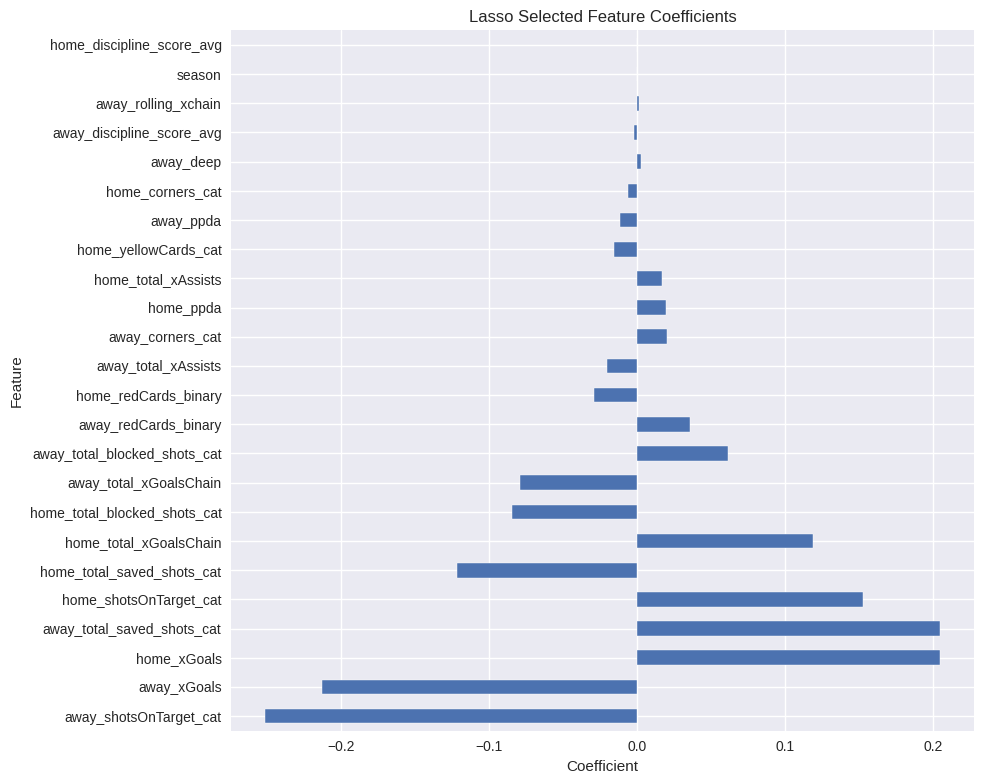

In [250]:
lasso_selected.plot(kind='barh', figsize=(10, 8))
plt.title("Lasso Selected Feature Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Variable Selection using Random Forest

In [251]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

rfmod = RandomForestClassifier().fit(X_scaled, y_clean)
#rfmod.feature_importances_ 

In [252]:
model = SelectFromModel(rfmod, prefit=True)
model.get_support()

array([False, False,  True, False, False,  True, False,  True, False,
        True,  True, False, False,  True, False,  True, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [253]:
selected_rf_features = X_model_input.columns[model.get_support()]


In [254]:
varSel['RandomForest'] = varSel['Variable'].isin(selected_rf_features).astype('int64')


In [255]:
varSel[varSel['RandomForest'] == 1]


,Variable,Univarable,Lasso,RandomForest
2,home_xGoals,1,1,1
5,home_ppda,1,1,1
7,home_total_xAssists,1,1,1
9,home_total_xGoalsChain,1,1,1
10,away_xGoals,1,1,1
13,away_ppda,1,1,1
15,away_total_xAssists,1,1,1
17,away_total_xGoalsChain,1,1,1
23,home_shotsOnTarget_cat,1,1,1
24,away_shotsOnTarget_cat,1,1,1


In [256]:
varSel['RandomForest'].sum()


11

In [257]:
# Intersection with Lasso
display(varSel[(varSel['RandomForest'] == 1) & (varSel['Lasso'] == 1)])

# Triple intersection: RF + Lasso + Univariate
display(varSel[(varSel['RandomForest'] == 1) & (varSel['Lasso'] == 1) & (varSel['Univarable'] == 1)])


,Variable,Univarable,Lasso,RandomForest
2,home_xGoals,1,1,1
5,home_ppda,1,1,1
7,home_total_xAssists,1,1,1
9,home_total_xGoalsChain,1,1,1
10,away_xGoals,1,1,1
13,away_ppda,1,1,1
15,away_total_xAssists,1,1,1
17,away_total_xGoalsChain,1,1,1
23,home_shotsOnTarget_cat,1,1,1
24,away_shotsOnTarget_cat,1,1,1


,Variable,Univarable,Lasso,RandomForest
2,home_xGoals,1,1,1
5,home_ppda,1,1,1
7,home_total_xAssists,1,1,1
9,home_total_xGoalsChain,1,1,1
10,away_xGoals,1,1,1
13,away_ppda,1,1,1
15,away_total_xAssists,1,1,1
17,away_total_xGoalsChain,1,1,1
23,home_shotsOnTarget_cat,1,1,1
24,away_shotsOnTarget_cat,1,1,1


In [258]:
rf = RandomForestClassifier(random_state=42)
model = SelectFromModel(estimator=rf)
model.fit(X_scaled, y_clean)

SelectFromModel(estimator=RandomForestClassifier(random_state=42))

In [259]:
importances = pd.Series(model.estimator_.feature_importances_, index=X_model_input.columns)
importances = importances[importances != 0].sort_values(ascending=False)
importances.head(20)


home_xGoals                   0.072925
away_xGoals                   0.066810
away_total_xAssists           0.051440
away_total_xGoalsChain        0.046328
home_total_xGoalsChain        0.045619
home_total_xAssists           0.041728
home_shotsOnTarget_cat        0.031404
away_shotsOnTarget_cat        0.030218
home_ppda                     0.026663
away_ppda                     0.023751
away_shot_conceded_ratio      0.020885
away_total_saved_shots_cat    0.020259
home_total_saved_shots_cat    0.020052
away_discipline_score_avg     0.020041
xchain_diff                   0.020025
ppda_diff                     0.019939
away_rolling_xchain           0.019909
home_discipline_score_avg     0.019740
points_diff                   0.019739
away_rolling_ppda             0.019530
dtype: float64

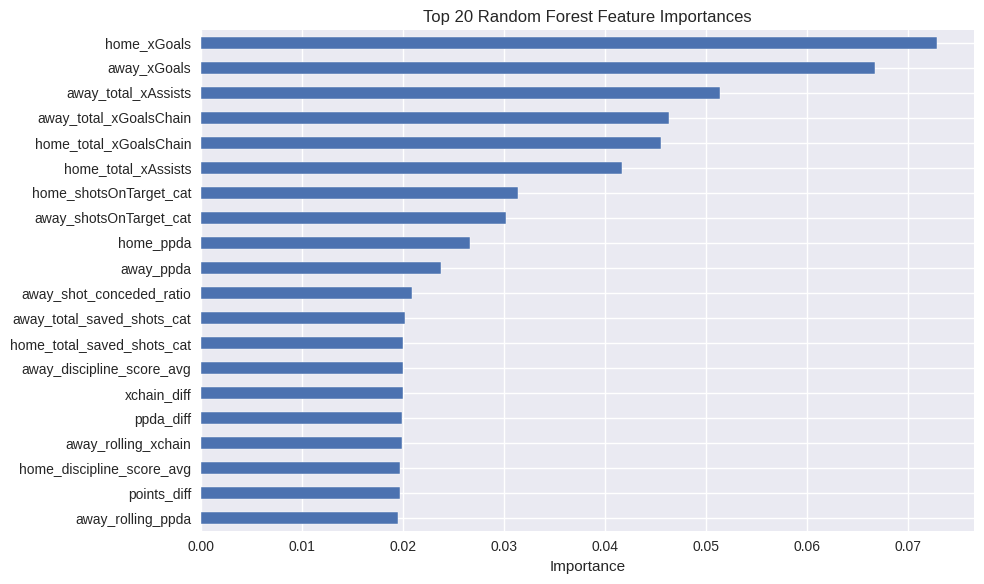

In [260]:
importances.head(20).plot(kind='barh', figsize=(10, 6))
plt.title("Top 20 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Variable Selection using Gradient Boosting classification

In [261]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

In [262]:
gbmod = GradientBoostingClassifier().fit(X_scaled, y_clean)

In [263]:
model = SelectFromModel(gbmod, prefit=True)
model.get_support()

array([False, False,  True, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [264]:
selected_gb_features = X_model_input.columns[model.get_support()]

In [265]:
varSel['GradienBoosting'] = varSel['Variable'].isin(selected_gb_features).astype('int64')


In [266]:
varSel[varSel['GradienBoosting'] == 1]


,Variable,Univarable,Lasso,RandomForest,GradienBoosting
2,home_xGoals,1,1,1,1
9,home_total_xGoalsChain,1,1,1,1
10,away_xGoals,1,1,1,1
17,away_total_xGoalsChain,1,1,1,1
23,home_shotsOnTarget_cat,1,1,1,1
24,away_shotsOnTarget_cat,1,1,1,1
29,home_total_saved_shots_cat,1,1,1,1
30,away_total_saved_shots_cat,1,1,0,1


In [267]:
varSel['GradienBoosting'].sum()


8

In [268]:
# Lasso & GB
display(varSel[(varSel['GradienBoosting'] == 1) & (varSel['Lasso'] == 1)])

# GB & Random Forest
display(varSel[(varSel['GradienBoosting'] == 1) & (varSel['RandomForest'] == 1)])

# Lasso & RF & GB
display(varSel[(varSel['GradienBoosting'] == 1) & 
       (varSel['RandomForest'] == 1) & 
       (varSel['Lasso'] == 1)])

# All 4: GB + RF + Lasso + Univariate
display(varSel[(varSel['GradienBoosting'] == 1) &
       (varSel['RandomForest'] == 1) &
       (varSel['Lasso'] == 1) &
       (varSel['Univarable'] == 1)])


,Variable,Univarable,Lasso,RandomForest,GradienBoosting
2,home_xGoals,1,1,1,1
9,home_total_xGoalsChain,1,1,1,1
10,away_xGoals,1,1,1,1
17,away_total_xGoalsChain,1,1,1,1
23,home_shotsOnTarget_cat,1,1,1,1
24,away_shotsOnTarget_cat,1,1,1,1
29,home_total_saved_shots_cat,1,1,1,1
30,away_total_saved_shots_cat,1,1,0,1


,Variable,Univarable,Lasso,RandomForest,GradienBoosting
2,home_xGoals,1,1,1,1
9,home_total_xGoalsChain,1,1,1,1
10,away_xGoals,1,1,1,1
17,away_total_xGoalsChain,1,1,1,1
23,home_shotsOnTarget_cat,1,1,1,1
24,away_shotsOnTarget_cat,1,1,1,1
29,home_total_saved_shots_cat,1,1,1,1


,Variable,Univarable,Lasso,RandomForest,GradienBoosting
2,home_xGoals,1,1,1,1
9,home_total_xGoalsChain,1,1,1,1
10,away_xGoals,1,1,1,1
17,away_total_xGoalsChain,1,1,1,1
23,home_shotsOnTarget_cat,1,1,1,1
24,away_shotsOnTarget_cat,1,1,1,1
29,home_total_saved_shots_cat,1,1,1,1


,Variable,Univarable,Lasso,RandomForest,GradienBoosting
2,home_xGoals,1,1,1,1
9,home_total_xGoalsChain,1,1,1,1
10,away_xGoals,1,1,1,1
17,away_total_xGoalsChain,1,1,1,1
23,home_shotsOnTarget_cat,1,1,1,1
24,away_shotsOnTarget_cat,1,1,1,1
29,home_total_saved_shots_cat,1,1,1,1


In [269]:
gb = GradientBoostingClassifier(random_state=42)
model = SelectFromModel(estimator=gb)
model.fit(X_scaled, y_clean)

SelectFromModel(estimator=GradientBoostingClassifier(random_state=42))

In [270]:
importances = pd.Series(model.estimator_.feature_importances_, index=X_model_input.columns)
importances = importances[importances != 0].sort_values(ascending=False)
importances.head(20)

home_xGoals                     0.173789
away_xGoals                     0.169211
home_shotsOnTarget_cat          0.149985
away_shotsOnTarget_cat          0.126858
home_total_saved_shots_cat      0.118215
away_total_saved_shots_cat      0.117711
home_total_xGoalsChain          0.035631
away_total_xGoalsChain          0.024596
away_total_xAssists             0.018126
home_total_blocked_shots_cat    0.013436
home_total_xAssists             0.009343
home_ppda                       0.007659
away_total_blocked_shots_cat    0.005703
away_ppda                       0.003323
home_yellowCards_cat            0.002299
home_shots                      0.002256
ppda_diff                       0.001461
away_fouls                      0.001420
points_diff                     0.001315
home_corners_cat                0.001314
dtype: float64

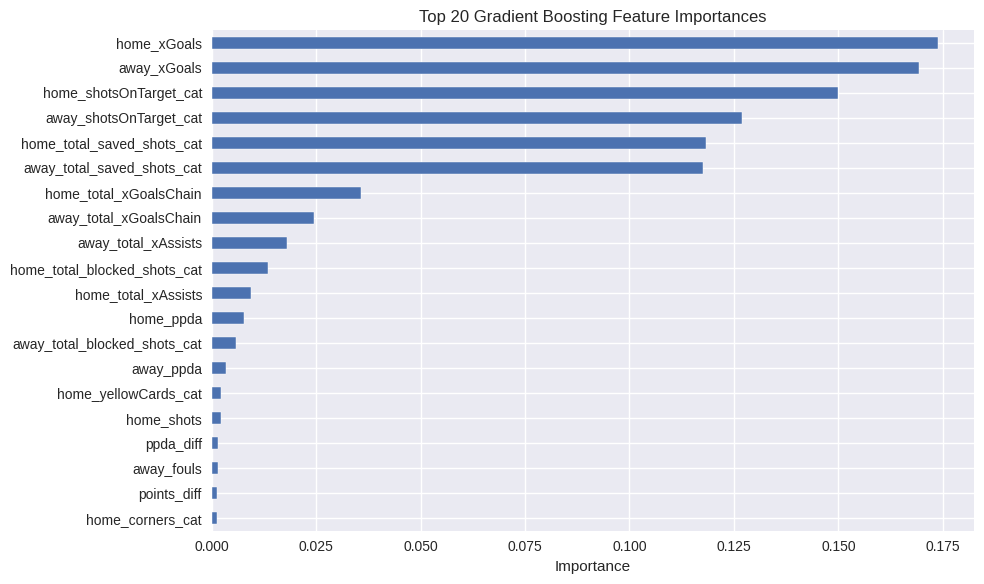

In [271]:
importances.head(20).plot(kind='barh', figsize=(10, 6))
plt.title("Top 20 Gradient Boosting Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Variable Selection using SVM classification

In [272]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

svmmod = LinearSVC(C=0.01, penalty="l1",dual=False).fit(X, y)

In [273]:
model = SelectFromModel(svmmod, prefit=True)
model.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True])

In [274]:
selected_svm_features = X_model_input.columns[model.get_support()]

In [275]:
varSel['SVM'] = varSel['Variable'].isin(selected_svm_features).astype('int64')


In [276]:
varSel[varSel['SVM'] == 1]

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM
0,leagueID,0,0,0,0,1
1,season,1,1,0,0,1
2,home_xGoals,1,1,1,1,1
3,home_shots,1,0,0,0,1
4,home_deep,1,0,0,0,1
5,home_ppda,1,1,1,0,1
6,home_fouls,1,0,0,0,1
8,home_total_key_passes,1,0,0,0,1
9,home_total_xGoalsChain,1,1,1,1,1
10,away_xGoals,1,1,1,1,1


In [277]:
varSel['SVM'].sum()


44

In [278]:
# Get absolute value of coefficients (shape: [n_classes, n_features])
coefs = np.abs(svmmod.coef_)  # shape: (n_classes, n_features)

# Reduce to one score per feature — use max or sum across classes
reduced_coefs = coefs.max(axis=0)  # or .sum(axis=0)

# Now match to column names
selected_svm_features = X_model_input.columns[reduced_coefs != 0]

In [279]:
svm_result = pd.Series(reduced_coefs, index=X_model_input.columns)
svm_result = svm_result[svm_result != 0].sort_values(ascending=False)
svm_result.head(20)

away_shotsOnTarget_cat          0.361269
away_xGoals                     0.296340
away_total_saved_shots_cat      0.286498
home_xGoals                     0.279487
home_shotsOnTarget_cat          0.227471
home_total_xGoalsChain          0.222444
home_total_saved_shots_cat      0.192922
home_total_blocked_shots_cat    0.132743
away_total_xGoalsChain          0.120962
away_total_blocked_shots_cat    0.107627
home_redCards_binary            0.052791
away_redCards_binary            0.052394
away_total_xAssists             0.046296
home_yellowCards_cat            0.046218
home_ppda                       0.035857
away_shots                      0.035295
away_total_key_passes           0.032551
away_corners_cat                0.031954
away_deep                       0.027696
away_fouls                      0.020684
dtype: float64

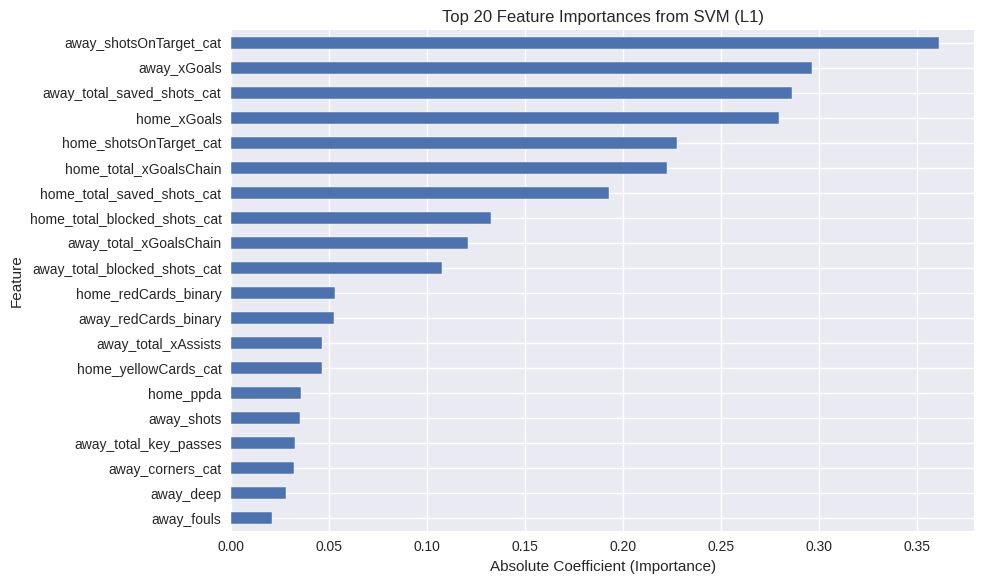

In [280]:
# Plot top 20 SVM feature importances
svm_result.head(20).plot(kind='barh', figsize=(10, 6))
plt.title("Top 20 Feature Importances from SVM (L1)")
plt.xlabel("Absolute Coefficient (Importance)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # So highest is on top
plt.tight_layout()
plt.show()

## Summarization and Selection of Variables


In [281]:
varSel['Sum'] =  np.sum(varSel,axis=1)
varSel

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM,Sum
0,leagueID,0,0,0,0,1,1
1,season,1,1,0,0,1,3
2,home_xGoals,1,1,1,1,1,5
3,home_shots,1,0,0,0,1,2
4,home_deep,1,0,0,0,1,2
5,home_ppda,1,1,1,0,1,4
6,home_fouls,1,0,0,0,1,2
7,home_total_xAssists,1,1,1,0,0,3
8,home_total_key_passes,1,0,0,0,1,2
9,home_total_xGoalsChain,1,1,1,1,1,5


In [282]:

varSel.groupby('Sum')['Variable'].count()

Sum
0     3
1    11
2    13
3    10
4     4
5     7
Name: Variable, dtype: int64

In [283]:
varSel[varSel['Sum']==5]

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM,Sum
2,home_xGoals,1,1,1,1,1,5
9,home_total_xGoalsChain,1,1,1,1,1,5
10,away_xGoals,1,1,1,1,1,5
17,away_total_xGoalsChain,1,1,1,1,1,5
23,home_shotsOnTarget_cat,1,1,1,1,1,5
24,away_shotsOnTarget_cat,1,1,1,1,1,5
29,home_total_saved_shots_cat,1,1,1,1,1,5


In [284]:
varSel[varSel['Sum']==3]

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM,Sum
1,season,1,1,0,0,1,3
7,home_total_xAssists,1,1,1,0,0,3
12,away_deep,1,1,0,0,1,3
19,home_redCards_binary,1,1,0,0,1,3
20,away_redCards_binary,1,1,0,0,1,3
21,home_yellowCards_cat,1,1,0,0,1,3
25,home_corners_cat,1,1,0,0,1,3
27,home_total_blocked_shots_cat,1,1,0,0,1,3
44,home_discipline_score_avg,1,1,0,0,1,3
45,away_discipline_score_avg,1,1,0,0,1,3


In [285]:
varSel[varSel['Sum']>=3]

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM,Sum
1,season,1,1,0,0,1,3
2,home_xGoals,1,1,1,1,1,5
5,home_ppda,1,1,1,0,1,4
7,home_total_xAssists,1,1,1,0,0,3
9,home_total_xGoalsChain,1,1,1,1,1,5
10,away_xGoals,1,1,1,1,1,5
12,away_deep,1,1,0,0,1,3
13,away_ppda,1,1,1,0,1,4
15,away_total_xAssists,1,1,1,0,1,4
17,away_total_xGoalsChain,1,1,1,1,1,5


In [286]:
varSel[varSel['Sum']>=2]

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM,Sum
1,season,1,1,0,0,1,3
2,home_xGoals,1,1,1,1,1,5
3,home_shots,1,0,0,0,1,2
4,home_deep,1,0,0,0,1,2
5,home_ppda,1,1,1,0,1,4
6,home_fouls,1,0,0,0,1,2
7,home_total_xAssists,1,1,1,0,0,3
8,home_total_key_passes,1,0,0,0,1,2
9,home_total_xGoalsChain,1,1,1,1,1,5
10,away_xGoals,1,1,1,1,1,5


In [287]:
type(varSel)

pandas.core.frame.DataFrame

In [288]:
final_var = varSel[varSel['Sum']>=2]['Variable'].tolist()
df_model = df[final_var].copy()
## add our Y 
df_model['gameresult'] = df['gameresult'].copy()

In [289]:
df_model.shape


(12680, 35)

In [290]:
df_model.to_csv('../csvs/df_model.csv')


In [291]:
# saving df for modeling
with open("../pickles/df_model.pkl", "wb") as f:
    pickle.dump(df_model, f)  # Save the DataFrame with standard pickle

## Setting proportion for Train, Test, Dev


In [292]:
from pyMechkar.analysis import train_test

In [293]:
train, temp = train_test(df_model, prop=0.6, seed=18)

Begining analysis...
Factorizing... please wait
***********************************
[]
************************************
************************************
[]
------ Finished in 13.537250280380249econds -----
['away_rolling_xchain']
You can try to change the seed value until you get a balanced partition.
Alternatively, you can ommit this warning and exclude those variables from your model
 


In [294]:
#60%
train.shape

(7608, 36)

In [295]:
df_object_train =  train.select_dtypes(include = ['object']).columns

## Encoding Categorial Data

In [296]:
# Select all categorical columns: both object and category
cat_cols = train.select_dtypes(include=['object', 'category']).columns

# Encode all of them
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
train[cat_cols] = ord_enc.fit_transform(train[cat_cols])

In [297]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7608 entries, 8859 to 11119
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   season                        7608 non-null   int64  
 1   home_xGoals                   7608 non-null   float64
 2   home_shots                    7608 non-null   float64
 3   home_deep                     7608 non-null   float64
 4   home_ppda                     7608 non-null   float64
 5   home_fouls                    7608 non-null   float64
 6   home_total_xAssists           7608 non-null   float64
 7   home_total_key_passes         7608 non-null   float64
 8   home_total_xGoalsChain        7608 non-null   float64
 9   away_xGoals                   7608 non-null   float64
 10  away_shots                    7608 non-null   float64
 11  away_deep                     7608 non-null   float64
 12  away_ppda                     7608 non-null   float64
 13 

In [298]:
train.to_csv('../csvs/Football_Database_train.csv')

In [299]:
# saving df after finishing feature engineering
with open("../pickles/train.pkl", "wb") as f:
    pickle.dump(train, f)  # Save the DataFrame with standard pickle

In [300]:

dev, test = train_test(temp, prop=0.5, seed=18)

Begining analysis...
Factorizing... please wait
***********************************
[]
************************************
************************************
[]
------ Finished in 12.537158489227295econds -----
 
You got a perfectly balanced training and test datasets
 


In [301]:
# Select all categorical columns: both object and category
cat_cols_test = test.select_dtypes(include=['object', 'category']).columns

ord_enc_test = OrdinalEncoder()
test[cat_cols] = ord_enc.fit_transform(test[cat_cols])

# Select all categorical columns: both object and category
cat_cols_dev = dev.select_dtypes(include=['object', 'category']).columns

ord_enc_dev = OrdinalEncoder()
dev[cat_cols] = ord_enc.fit_transform(dev[cat_cols])

In [302]:
#50%
test.shape

(2536, 36)

In [303]:
test.to_csv('../csvs/Football_Database_test.csv')

# saving df after finishing feature engineering
with open("../pickles/test.pkl", "wb") as f:
    pickle.dump(test, f)  # Save the DataFrame with standard pickle

In [304]:
test

,season,home_xGoals,home_shots,home_deep,home_ppda,home_fouls,home_total_xAssists,home_total_key_passes,home_total_xGoalsChain,away_xGoals,...,home_total_blocked_shots_cat,away_total_blocked_shots_cat,home_total_saved_shots_cat,away_total_saved_shots_cat,time_category,away_rolling_xchain,home_discipline_score_avg,away_discipline_score_avg,gameresult,split
9123,2018,1.354740,10.000000,5.000000,6.1111,12.0,1.182628,4.0,1.025618,0.484752,...,3.0,4.0,2.0,4.0,1.0,0.000000,-27.999720,-25.999740,2,0.0
809,2015,1.030380,19.000000,13.000000,2.2500,17.0,0.634875,15.0,2.760650,0.263110,...,9.0,2.0,3.0,2.0,1.0,1.657772,-26.928552,-27.785694,1,0.0
780,2015,0.744526,15.000000,3.000000,7.5758,19.0,0.541279,11.0,1.120400,1.413000,...,6.0,6.0,2.0,2.0,0.0,2.264199,-22.328979,-24.104162,0,0.0
265,2015,2.074880,11.000000,13.000000,10.8571,14.0,1.528366,7.0,5.236435,1.216380,...,1.0,5.0,2.0,0.0,1.0,3.349545,-21.374035,-20.793102,2,0.0
12190,2020,1.754310,13.484856,6.142375,3.3704,14.0,1.073796,16.0,4.081372,0.547118,...,9.0,1.0,7.0,1.0,1.0,2.879728,-20.874974,-20.111089,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4626,2014,1.495350,16.000000,11.000000,10.6190,12.0,0.552496,11.0,3.685556,3.363920,...,4.0,4.0,5.0,4.0,1.0,1.284575,-15.459455,-17.810806,0,0.0
11262,2020,1.474980,13.000000,8.000000,7.6000,13.0,1.323135,11.0,1.247887,1.407060,...,3.0,2.0,5.0,2.0,1.0,2.133174,-24.653274,-22.076915,0,0.0
3731,2014,0.600074,8.000000,7.000000,10.0000,10.0,0.570147,7.0,2.078904,1.517170,...,2.0,2.0,1.0,1.0,1.0,2.206263,-16.821423,-19.357136,0,0.0
439,2016,0.569734,13.000000,2.000000,10.9583,11.0,0.522914,10.0,0.855076,0.776105,...,6.0,6.0,2.0,2.0,1.0,5.826067,-20.799915,-23.943394,2,0.0


In [305]:
dev.to_csv('../csvs/Football_Database_dev.csv')

# saving df after finishing feature engineering
with open("../pickles/dev.pkl", "wb") as f:
    pickle.dump(dev, f)  # Save the DataFrame with standard pickle

In [306]:
dev

,season,home_xGoals,home_shots,home_deep,home_ppda,home_fouls,home_total_xAssists,home_total_key_passes,home_total_xGoalsChain,away_xGoals,...,home_total_blocked_shots_cat,away_total_blocked_shots_cat,home_total_saved_shots_cat,away_total_saved_shots_cat,time_category,away_rolling_xchain,home_discipline_score_avg,away_discipline_score_avg,gameresult,split
10682,2019,0.537278,11.0,1.0,8.2727,17.000000,0.422670,8.0,1.474588,5.346760,...,4.0,7.0,4.0,7.0,1.0,2.051656,-19.663184,-22.828121,0,0.0
10794,2019,1.027300,14.0,3.0,18.6000,12.000000,0.940323,11.0,3.602186,0.716385,...,3.0,4.0,5.0,2.0,1.0,4.126528,-18.166657,-22.363626,1,0.0
2455,2016,1.082450,9.0,3.0,9.6667,12.597074,0.972738,6.0,4.311075,0.505706,...,2.0,1.0,1.0,3.0,1.0,0.715211,-21.741990,-23.285681,2,0.0
6463,2017,0.106979,2.0,3.0,10.0000,14.000000,0.082412,1.0,0.519041,1.471830,...,0.0,2.0,0.0,7.0,0.0,2.515082,-19.282605,-19.195648,0,0.0
168,2015,0.973378,22.0,10.0,5.4706,6.000000,0.720419,14.0,2.698206,0.401988,...,9.0,3.0,2.0,2.0,1.0,3.023091,-21.985502,-24.942854,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475,2016,1.256860,15.0,6.0,4.4286,11.000000,1.062406,12.0,4.798060,0.234038,...,4.0,1.0,3.0,2.0,1.0,2.481657,-25.599949,-23.999952,1,0.0
1487,2015,0.138495,4.0,5.0,6.5957,22.000000,0.125602,3.0,0.304673,1.003940,...,1.0,3.0,1.0,2.0,1.0,2.887362,-21.183210,-23.683331,1,0.0
4070,2014,1.424000,16.0,5.0,4.9200,16.000000,1.139164,9.0,7.039235,1.329110,...,9.0,2.0,2.0,0.0,0.0,6.825914,-12.564515,-15.306450,0,0.0
4404,2014,2.011290,7.0,5.0,11.8261,10.000000,1.141297,4.0,5.769247,2.038150,...,0.0,4.0,1.0,4.0,0.0,4.435367,-13.433329,-16.699994,2,0.0


In [307]:
dev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2536 entries, 10682 to 9411
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   season                        2536 non-null   int64  
 1   home_xGoals                   2536 non-null   float64
 2   home_shots                    2536 non-null   float64
 3   home_deep                     2536 non-null   float64
 4   home_ppda                     2536 non-null   float64
 5   home_fouls                    2536 non-null   float64
 6   home_total_xAssists           2536 non-null   float64
 7   home_total_key_passes         2536 non-null   float64
 8   home_total_xGoalsChain        2536 non-null   float64
 9   away_xGoals                   2536 non-null   float64
 10  away_shots                    2536 non-null   float64
 11  away_deep                     2536 non-null   float64
 12  away_ppda                     2536 non-null   float64
 13 